# Linear Regression

This project is for making a linear regression model for joint angle prediction

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

The dataset needs to be restructured for linear regression.
We don't need the gesture labels anymore, since our target is just joint angles.
We need to window the joint angles too. For simplicity we will average the 200ms window of joint angle data.

# Dataset export to get glove kinematic target values

In [2]:
"""
Features (from SEED dataset)
"""

def MAV(data):
    """
    :param data: 2D array, channels x samples
    :return: MAV of the data
    """
    return np.mean(np.abs(data), axis=1).reshape((1, data.shape[0]))

def VAR(data):
    """
    Variance
    :param data: 2D array, channels x samples
    :return: Variance of the data
    """
    return np.var(data, axis=1).reshape((1, data.shape[0]))

def RMS(data):
    """
    Root mean square
    :param data: 2D array, channels x samples
    :return: RMS per channel
    """
    return np.sqrt(np.mean(data**2, axis=1)).reshape((1, data.shape[0]))

def zero_crossings(data):
    """
    Number of zero crossings from each channel
    :param data: 2D array, channels x samples
    :return: number of zero crossings for each channel
    """
    positive = data > 0
    return np.sum(np.bitwise_xor(positive[:, 1:], positive[:, :-1]), axis=1).reshape((1, data.shape[0]))

def avg_amplitude_change(data):
    """
    https://www.sciencedirect.com/science/article/pii/S0957417412001200
    :param data: 2D array, channels x samples
    :return: Average amplitude change (AAC) as defined in the reference above
    """
    return np.mean(np.abs(np.diff(data, axis=1)), axis=1).reshape((1, data.shape[0]))

"""Additional frequency domain features"""

def spectral_centroid(data):
    """
    Spectral Centroid
    :param data: 2D array, channels x samples
    :return: Spectral centroid per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    return centroid.reshape((1, data.shape[0]))


def spectral_spread(data):
    """
    Spectral Spread
    :param data: 2D array, channels x samples
    :return: Spectral spread per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    # Spectral centroid
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    
    # Spectral spread (standard deviation around centroid)
    spread = np.sqrt(
        np.sum(spectrum * (freqs - centroid[:, None])**2, axis=1) / denom
    )
    
    return spread.reshape((1, data.shape[0]))

In [3]:
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Create a dataset for classification training/testing.
Each participant is stored in a separate file.
"""

def extract_windows_glove(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        win_data = np.mean(win_data, axis=1)
        windows.append(win_data)
    return np.array(windows)

def extract_windows(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        windows.append(win_data)
    return windows

def num_windows(length, window_size, window_step):
    return int(math.floor((length - window_size) / window_step)) + 1

def extract_features_by_window(data, num_windows, window_size, window_step):
    """
    Splits data set into windows, extracts features for each window
    """

    feature_names = ['mav', 'var', 'rms', 'zcr', 'aac', 'sc', 'ss']

    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]

        feature_array = []
        feature_array.append(MAV(win_data))
        feature_array.append(VAR(win_data))
        feature_array.append(RMS(win_data))
        feature_array.append(zero_crossings(win_data))
        feature_array.append(avg_amplitude_change(win_data))
        feature_array.append(spectral_centroid(win_data))
        feature_array.append(spectral_spread(win_data))
        
        windows.append(feature_array)
    return windows, feature_names


# file handling
ROOT = Path.cwd()
LABELS = ROOT / 'labels'
DATA = ROOT / 'pkl_dataset_resampled'

# windowing
FS = 512
WINDOW_SIZE = int(0.2*FS)   # 200 ms windows
WINDOW_HOP = WINDOW_SIZE // 2 # 50% overlap (NOTE: WINDOW_HOP = WINDOW_SIZE - WINDOW_OVERLAP)

## Load labels data
labels = pd.read_csv(LABELS / 'labels.csv', index_col=False)
kill_list = pd.read_csv(LABELS / 'kill_list.csv', index_col=False)
kill_list = kill_list['file'].to_list()

## Create empty data frame for all data
dataset_columns = {'movement': [], 'joints': [], 'speed': [], 'subject': [], 'session': [], 'trial': [], 'windows_raw': [], 'windows_feature': []}
df = pd.DataFrame(dataset_columns)

## Load in dataset
dirs = [entry.name for entry in os.scandir(DATA) if entry.is_dir()]
for dir in dirs:
    files = [x for x in os.listdir(DATA / dir) if '.pkl' in x]
    for file in files:
        # load data file
        temp = pd.read_pickle(DATA / dir / file)

        if temp['movement'] == 'disc' or temp['movement'] == 'thumbAdd' or temp['movement'] == 'middle' or temp['movement'] == 'index' or file in kill_list:
            continue

        temp_row = dataset_columns.copy()

        # get labels
        file_labs = labels.loc[labels['file'] == file].to_dict(orient='records') # note if this returns more than 1 row something is wrong
        # print(file_labs)
        try:
            file_labs = file_labs[0]
            try:
                start_sample = int(file_labs['start'] * FS)
                end_sample = int(file_labs['end'] * FS)
                # print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            except:
                raise ValueError(f'Could not access start')
        except:
                print(f"Could not find labels for file {file}")
                print(f"Movement: {temp['movement']} | Speed: {temp['speed']}")
        
        if end_sample < start_sample:
            print(f"Start time was less than end time for file {file}")
            print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            print("Continuing to next file")
            continue

        emg = temp['emg']
        joints = temp['glove']

        # extract windows
        n_windows = num_windows(emg.shape[1], WINDOW_SIZE, WINDOW_HOP)
        windows = extract_windows(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        joints = extract_windows_glove(joints, n_windows, WINDOW_SIZE, WINDOW_HOP)
        feature_windows, feature_names = extract_features_by_window(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)

        ## append data to dataframe
        temp_row['windows_raw'] = windows
        temp_row['windows_feature'] = feature_windows
        temp_row['joints'] = joints
        temp_row['speed'] = str(temp['speed'][0])
        temp_row['subject'] = str(temp['subject'][0])
        temp_row['movement'] = str(temp['movement'][0])
        temp_row['session'] = int(temp['session'][0][0])
        temp_row['trial'] = int(str(file).split('.')[0].split('_')[-1])

        df_the_dict = pd.DataFrame([temp_row])
        df = pd.concat([df, df_the_dict], ignore_index=True)

Start time was less than end time for file detop_exp01_subj10_Sess1_13_04.pkl
Start time: 0.58984375 | End time: 0.0
Continuing to next file
Could not find labels for file detop_exp01_subj03_Sess3_07_04.pkl
Movement: ['cilinder'] | Speed: ['fast']
Start time was less than end time for file detop_exp01_subj04_Sess1_05_01.pkl
Start time: 1.8515625 | End time: 0.6796875
Continuing to next file
Could not find labels for file detop_exp01_subj04_Sess1_03_05.pkl
Movement: ['point'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess2_11_02.pkl
Movement: ['pinch'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_05_06.pkl
Movement: ['3digit'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj02_Sess3_02_02.pkl
Movement: ['index_flex'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj01_Sess2_13_01.pkl
Movement: ['point'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj01_Sess1_12_06.pkl
Movement: ['in

In [4]:
df.to_pickle('dataset_regression.pkl')

In [5]:
dataset = pickle.load(open('dataset_regression.pkl', 'rb'))

# Joint angle regression starts here

In [6]:
### Joint angles regression

import numpy as np

def reshape_data_windows_regression(X, y):
    """
    Converts:
        X: recordings x windows x features x channels
        y: recordings x windows x output_channels

    To:
        X_out: total_windows x (features * channels)
        y_out: total_windows x output_channels
    """

    X_list = list(X)
    y_list = list(y)

    X_windows = []
    y_windows = []

    for rec_idx, (rec_X, rec_y) in enumerate(zip(X_list, y_list)):
        rec_X = np.asarray(rec_X)
        rec_y = np.asarray(rec_y)

        # Skip recordings with no windows
        if rec_X.shape[0] == 0:
            continue

        # Sanity check
        if rec_X.shape[0] != rec_y.shape[0]:
            raise ValueError(
                f"Window mismatch in recording {rec_idx}: "
                f"X has {rec_X.shape[0]}, y has {rec_y.shape[0]}"
            )

        for w in range(rec_X.shape[0]):
            # Flatten features x channels → 938
            X_windows.append(rec_X[w].reshape(-1))
            y_windows.append(rec_y[w])  # shape: (18,)

    X_out = np.asarray(X_windows)
    y_out = np.asarray(y_windows)

    return X_out, y_out


dataset = pd.read_pickle('dataset_regression.pkl')

## RIDGE REGRESSION NO PCA


alpha: 1.832e-02   (1/10)
  Fold 1/10  Val R²: -5.747  Train R²: 0.559
  Fold 2/10  Val R²: 0.534  Train R²: 0.559
  Fold 3/10  Val R²: -1171.768  Train R²: 0.560
  Fold 4/10  Val R²: 0.540  Train R²: 0.560
  Fold 5/10  Val R²: 0.513  Train R²: 0.559
  Fold 6/10  Val R²: 0.506  Train R²: 0.560
  Fold 7/10  Val R²: 0.510  Train R²: 0.559
  Fold 8/10  Val R²: -7613.111  Train R²: 0.561
  Fold 9/10  Val R²: -2298.226  Train R²: 0.560
  Fold 10/10  Val R²: 0.541  Train R²: 0.559

alpha: 4.455e-02   (2/10)
  Fold 1/10  Val R²: -4.098  Train R²: 0.559
  Fold 2/10  Val R²: 0.534  Train R²: 0.558
  Fold 3/10  Val R²: -868.486  Train R²: 0.560
  Fold 4/10  Val R²: 0.540  Train R²: 0.560
  Fold 5/10  Val R²: 0.521  Train R²: 0.559
  Fold 6/10  Val R²: 0.512  Train R²: 0.560
  Fold 7/10  Val R²: 0.515  Train R²: 0.559
  Fold 8/10  Val R²: -6291.221  Train R²: 0.561
  Fold 9/10  Val R²: -2007.865  Train R²: 0.560
  Fold 10/10  Val R²: 0.541  Train R²: 0.559

alpha: 1.084e-01   (3/10)
  Fold 1/10 

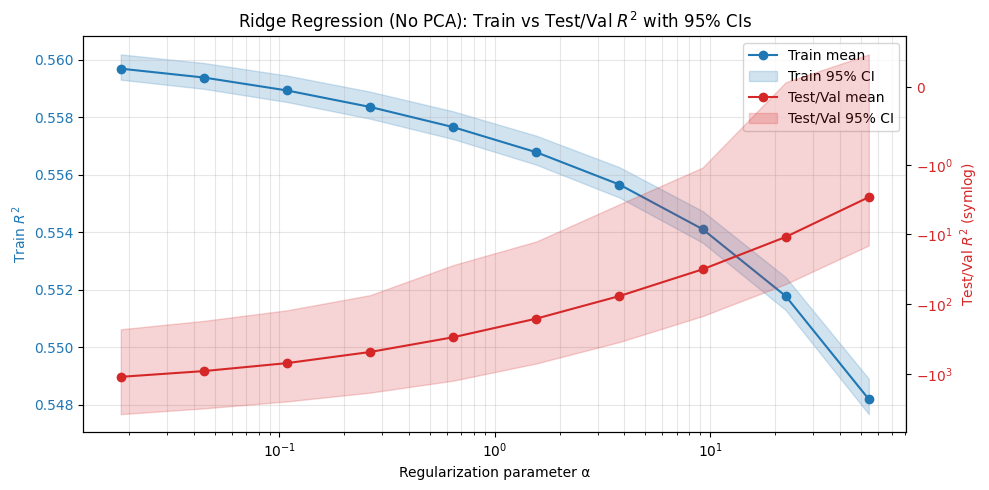

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 10
alphas = np.exp(np.linspace(-4, 4, n))
num_folds = 10

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")

# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax_train = plt.subplots(figsize=(10, 5))
ax_val = ax_train.twinx()

# Shared X (log scale for alpha)
ax_train.set_xscale("log")

# ---- Training (left axis, linear) ----
train_line = ax_train.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")[0]
ax_train.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax_train.set_ylabel("Train $R^2$", color="tab:blue")
ax_train.tick_params(axis="y", labelcolor="tab:blue")

# ---- Testing/Validation (right axis, symlog to handle huge negatives) ----
val_line = ax_val.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")[0]
ax_val.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")

# symlog works with negative + positive values (unlike log)
ax_val.set_yscale("symlog", linthresh=1.0, base=10)
ax_val.set_ylabel("Test/Val $R^2$ (symlog)", color="tab:red")
ax_val.tick_params(axis="y", labelcolor="tab:red")

# ---- Labels / title / legend ----
ax_train.set_xlabel("Regularization parameter α")
ax_train.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs")
ax_train.grid(True, which="both", alpha=0.3)

# Combine legends from both axes
h1, l1 = ax_train.get_legend_handles_labels()
h2, l2 = ax_val.get_legend_handles_labels()
ax_train.legend(h1 + h2, l1 + l2, loc="best")

plt.tight_layout()
plt.show()

## THERE IS A NEED TO KEEP GOING WITH MORE REGULARIZATION


alpha: 1.000e-04   (1/20)
  Fold 1/5  Val R²: -11.885  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1814.949  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.493  Train R²: 0.559

alpha: 2.637e-04   (2/20)
  Fold 1/5  Val R²: -11.634  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1802.961  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.494  Train R²: 0.559

alpha: 6.952e-04   (3/20)
  Fold 1/5  Val R²: -11.057  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1772.678  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.495  Train R²: 0.559

alpha: 1.833e-03   (4/20)
  Fold 1/5  Val R²: -9.937  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1700.690  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.497  Train R²: 0.559

alpha: 4

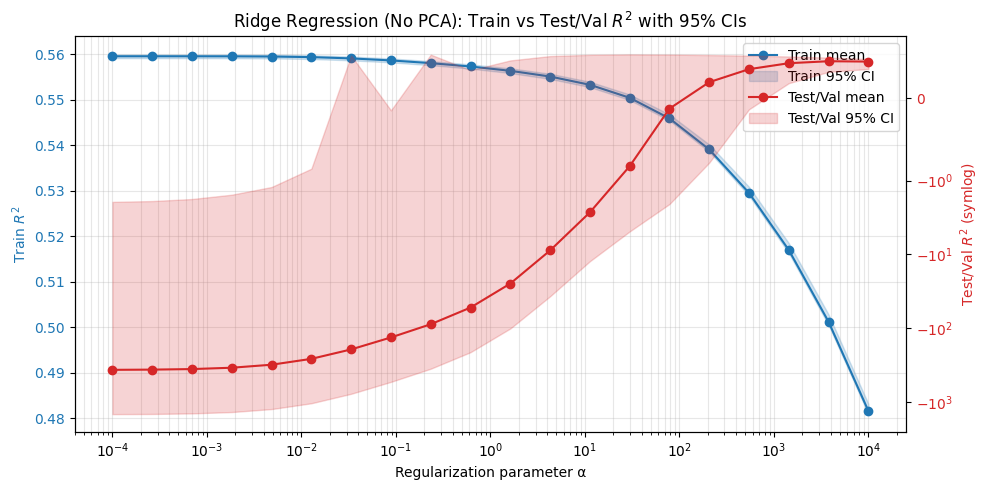

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 20
alphas = np.exp(np.linspace(-4*np.log(10), 4*np.log(10), n))  # 1e-4 ... 1e4
num_folds = 5

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")

# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax_train = plt.subplots(figsize=(10, 5))
ax_val = ax_train.twinx()

# Shared X (log scale for alpha)
ax_train.set_xscale("log")

# ---- Training (left axis, linear) ----
train_line = ax_train.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")[0]
ax_train.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax_train.set_ylabel("Train $R^2$", color="tab:blue")
ax_train.tick_params(axis="y", labelcolor="tab:blue")

# ---- Testing/Validation (right axis, symlog to handle huge negatives) ----
val_line = ax_val.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")[0]
ax_val.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")

# symlog works with negative + positive values (unlike log)
ax_val.set_yscale("symlog", linthresh=1.0, base=10)
ax_val.set_ylabel("Test/Val $R^2$ (symlog)", color="tab:red")
ax_val.tick_params(axis="y", labelcolor="tab:red")

# ---- Labels / title / legend ----
ax_train.set_xlabel("Regularization parameter α")
ax_train.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs")
ax_train.grid(True, which="both", alpha=0.3)

# Combine legends from both axes
h1, l1 = ax_train.get_legend_handles_labels()
h2, l2 = ax_val.get_legend_handles_labels()
ax_train.legend(h1 + h2, l1 + l2, loc="best")

plt.tight_layout()
plt.show()

This helped. Trying to zoom in on that range past 10^2 and using the same scale.


alpha: 1.000e+02   (1/10)
  Fold 1/5  Val R²: 0.509  Train R²: 0.544
  Fold 2/5  Val R²: 0.534  Train R²: 0.544
  Fold 3/5  Val R²: -2.213  Train R²: 0.546
  Fold 4/5  Val R²: 0.531  Train R²: 0.545
  Fold 5/5  Val R²: 0.538  Train R²: 0.544

alpha: 2.154e+02   (2/10)
  Fold 1/5  Val R²: 0.509  Train R²: 0.538
  Fold 2/5  Val R²: 0.530  Train R²: 0.538
  Fold 3/5  Val R²: -1.063  Train R²: 0.540
  Fold 4/5  Val R²: 0.526  Train R²: 0.539
  Fold 5/5  Val R²: 0.533  Train R²: 0.538

alpha: 4.642e+02   (3/10)
  Fold 1/5  Val R²: 0.509  Train R²: 0.531
  Fold 2/5  Val R²: 0.525  Train R²: 0.530
  Fold 3/5  Val R²: -0.395  Train R²: 0.533
  Fold 4/5  Val R²: 0.519  Train R²: 0.531
  Fold 5/5  Val R²: 0.527  Train R²: 0.531

alpha: 1.000e+03   (4/10)
  Fold 1/5  Val R²: 0.507  Train R²: 0.521
  Fold 2/5  Val R²: 0.518  Train R²: 0.521
  Fold 3/5  Val R²: -0.010  Train R²: 0.524
  Fold 4/5  Val R²: 0.511  Train R²: 0.522
  Fold 5/5  Val R²: 0.519  Train R²: 0.522

alpha: 2.154e+03   (5/10)
 

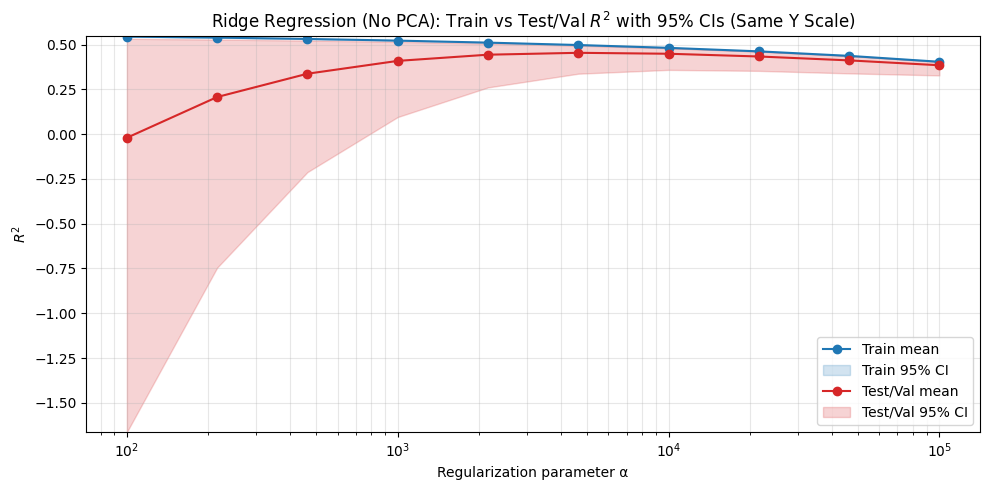

In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 10
alphas = np.exp(np.linspace(2*np.log(10), 5*np.log(10), n))  # 1e2 ... 1e5
num_folds = 5

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")

# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xscale("log")
ax.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")
ax.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")
ax.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")
y_min = float(min(ci_lows_train.min(), ci_lows.min()))
y_max = float(max(ci_highs_train.max(), ci_highs.max()))
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Regularization parameter α")
ax.set_ylabel("$R^2$")
ax.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs (Same Y Scale)")
ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# NOW LET US ADD SOME PRE PROCESSING

## WITH PCA


Ridge Regression WITH PCA:
alpha: 1.832e-02
  Val R²: 0.125, Train R²: 0.124
alpha: 4.455e-02
  Val R²: 0.125, Train R²: 0.124
alpha: 1.084e-01
  Val R²: 0.125, Train R²: 0.124
alpha: 2.636e-01
  Val R²: 0.125, Train R²: 0.124
alpha: 6.412e-01
  Val R²: 0.125, Train R²: 0.124
alpha: 1.560e+00
  Val R²: 0.125, Train R²: 0.124
alpha: 3.794e+00
  Val R²: 0.125, Train R²: 0.124
alpha: 9.228e+00
  Val R²: 0.125, Train R²: 0.124
alpha: 2.245e+01
  Val R²: 0.125, Train R²: 0.124
alpha: 5.460e+01
  Val R²: 0.125, Train R²: 0.124


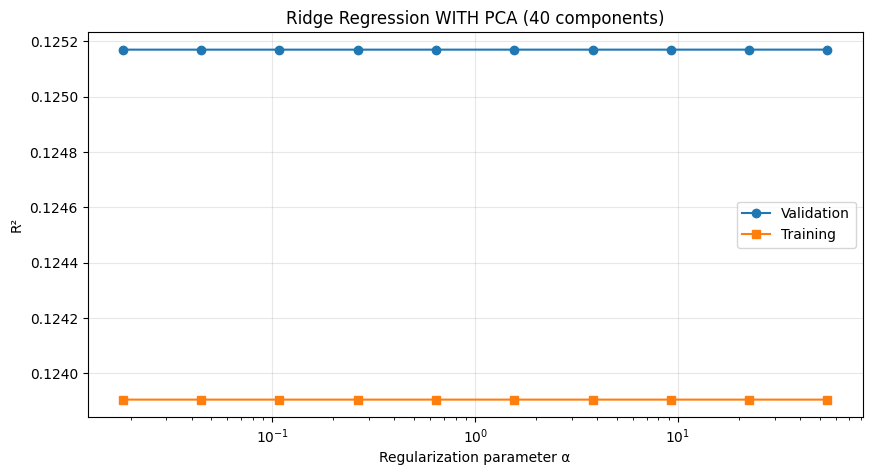


Best PCA R²: 0.125 at α=5.460e+01


In [5]:
from sklearn.decomposition import PCA

print("\nRidge Regression WITH PCA:")
n = 10
alphas = np.exp(np.linspace(-4, 4, n))
n_components = 40

r2_val_pca = []
r2_train_pca = []

for alpha_j in alphas:
    print(f'alpha: {alpha_j:.3e}')
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_full)
    
    # Scale after PCA
    scaler = StandardScaler()
    X_train_pca = scaler.fit_transform(X_train_pca)
    
    # Split for validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_pca, y_train_full,
        test_size=0.2,
        random_state=42
    )
    
    reg = Ridge(alpha=alpha_j)
    reg.fit(X_tr, y_tr)
    
    y_val_pred = reg.predict(X_val)
    y_tr_pred = reg.predict(X_tr)
    
    r2_val_pca.append(r2_score(y_val, y_val_pred, multioutput='uniform_average'))
    r2_train_pca.append(r2_score(y_tr, y_tr_pred, multioutput='uniform_average'))
    
    print(f'  Val R²: {r2_val_pca[-1]:.3f}, Train R²: {r2_train_pca[-1]:.3f}')

plt.figure(figsize=(10, 5))
plt.semilogx(alphas, r2_val_pca, 'o-', label='Validation')
plt.semilogx(alphas, r2_train_pca, 's-', label='Training')
plt.xlabel('Regularization parameter α')
plt.ylabel('R²')
plt.title(f'Ridge Regression WITH PCA ({n_components} components)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f'\nBest PCA R²: {max(r2_val_pca):.3f} at α={alphas[np.argmax(r2_val_pca)]:.3e}')

## KERNEL RIDGE WITH RBF

In [6]:
from sklearn.kernel_ridge import KernelRidge

print("\nKernel Ridge Regression with RBF kernel (full):")
gammas = [0.001, 0.01, 0.1, 1.0]
alphas_kernel = [0.1, 1.0, 10.0, 100.0]

results_rbf = []

# Scale data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

for gamma in gammas:
    for alpha_k in alphas_kernel:
        print(f'gamma: {gamma}, alpha: {alpha_k}')
        
        # Split for validation
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_scaled, y_train_full,
            test_size=0.2,
            random_state=42
        )
        
        krr = KernelRidge(alpha=alpha_k, kernel='rbf', gamma=gamma)
        krr.fit(X_tr, y_tr)
        
        y_val_pred = krr.predict(X_val)
        y_tr_pred = krr.predict(X_tr)
        
        r2_val = r2_score(y_val, y_val_pred, multioutput='uniform_average')
        r2_train = r2_score(y_tr, y_tr_pred, multioutput='uniform_average')
        
        results_rbf.append({
            'gamma': gamma,
            'alpha': alpha_k,
            'r2_val': r2_val,
            'r2_train': r2_train
        })
        
        print(f'  Val R²: {r2_val:.3f}, Train R²: {r2_train:.3f}')

# Show best result
best_rbf = max(results_rbf, key=lambda x: x['r2_val'])
print(f"\nBest RBF: gamma={best_rbf['gamma']}, alpha={best_rbf['alpha']}, R²={best_rbf['r2_val']:.3f}")


Kernel Ridge Regression with RBF kernel (full):
gamma: 0.001, alpha: 0.1


MemoryError: Unable to allocate 49.1 GiB for an array with shape (81146, 81146) and data type float64